In [ ]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
plt.style.use('seaborn-v0_8')
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
boston_data = pd.read_csv('housing.csv', header=None, delimiter=r"\s+", names=column_names)
boston_data.describe()

Построим линейную регрессию на одном признаке. Выберем признак, который имеет наиболее высокую линейную взаимосвязь. Для этого рассчитаем корреляцию признаков с целевой переменной и выберем наиболее влиятельный.
Мы могли визуализировать матрицу корреляций, однако сейчас нас интересует только связь факторов с целевым признаком, поэтому нагляднее будет воспользоваться столбчатой диаграммой.

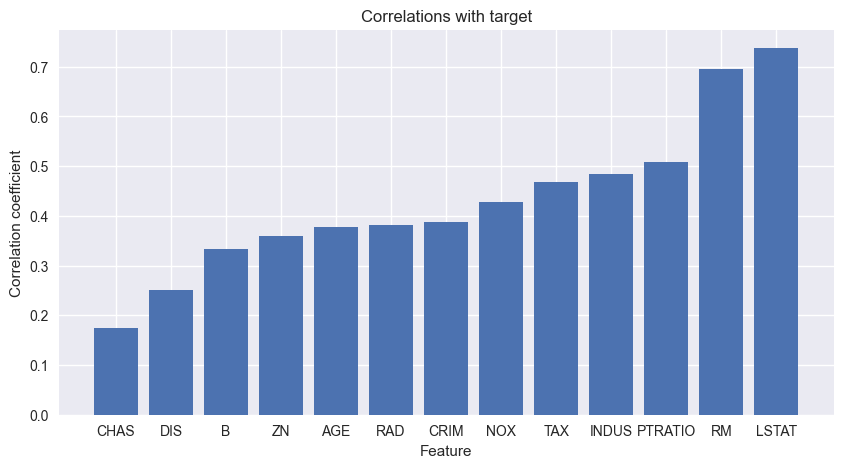

In [6]:
#Вычисляем модуль корреляции
corr_with_target = boston_data.corr()['MEDV'].abs().sort_values()
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('MEDV')
#Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(10, 5)) #фигура+координатная плоскость
ax.bar(corr_with_target.index, corr_with_target.values) #столбчатая диаграмма
ax.set_title('Correlations with target') #название графика
ax.set_xlabel('Feature') #название оси x
ax.set_ylabel('Сorrelation coefficient'); #название оси y

Итак, самый коррелированный по модулю с медианной ценой (MEDV) признак — процент населения с низким статусом (LSTAT). Давайте построим линейную регрессию, используя этот признак.
Построить линейную регрессию = обучить линейную регрессию = найти её параметры.

Вспоминаем нашу формулу аналитического решения по методу наименьших квадратов:
Что есть X и y ? Это матрица из примеров (матрица наблюдений) и вектор правильных ответов к ним соответственно. У нас матрица X — это таблица, состоящая из одного столбца (LSTAT), а y — столбец с медианными ценами (MEDV):

In [7]:
X = boston_data[['LSTAT']] #матрица наблюдений
y = boston_data['MEDV'] #вектор правильных ответов
X.head()
#y.head()
#Двойные квадратные скобки boston_data[['LSTAT']] позволяют выбрать признак из DataFrame, 
#сохранив его в виде таблицы. Это важно, так как в формуле МНК  — это матрица.

,LSTAT
0,4.98
1,9.14
2,4.03
3,2.94
4,5.33


Давайте напишем функцию linear_regression(), в которой реализуем вычисления коэффициентов. Аргументами функции будут матрица наблюдений X и вектор ответов y, а возвращать она будет вектор параметров w.
Для начала вспомним, что для вычисления свободного члена  необходимо добавить в таблицу столбец, полностью состоящий из единиц. Такой столбец можно создать с помощью знакомой нам функции ones() из библиотеки numpy, а присоединить его к таблице X поможет функция column_stack().

Матричное умножение в numpy реализуется с помощью оператора @. Транспонирование осуществляется через .T, а обратная матрица вычисляется с помощью функции inv() из модуля linalg (модуля для линейной алгебры).

In [9]:
def linear_regression(X, y):
    #Создаём вектор из единиц
    ones = np.ones(X.shape[0])
    #Добавляем вектор к таблице первым столбцом
    X = np.column_stack([ones, X])
    #Вычисляем обратную матрицу Q
    Q = np.linalg.inv(X.T @ X)
    #Вычисляем вектор коэффициентов
    w = Q @ X.T @ y
    return w

Осталось только вызвать нашу функцию и передать в неё нашу таблицу примеров X и столбец правильных ответов y. Вычислим вектор параметров и выведем его на экран:

In [10]:
#Вычисляем параметры линейной регрессии
w = linear_regression(X, y)
#Выводим вычисленные значения параметров в виде вектора
print('Vector w: {}'.format(w))
#Выводим параметры с точностью до двух знаков после запятой
print('w0: {:.2f}'.format(w[0]))
print('w1: {:.2f}'.format(w[1]))
# Vector w: [34.55384088 -0.95004935]
# w0: 34.55
# w1: -0.95

Vector w: [34.55384088 -0.95004935]
w0: 34.55
w1: -0.95


Итак, мы получили значения коэффициентов уравнения прямой.
А значит сама модель будет иметь вид:
y = 34.55-0.95x1
Коэффициент  имитирует влияние сторонних факторов, которые не учтены в модели. Это значение медианной цены домов на участке, если бы значение процента населения с низким статусом было равно 0. 

Коэффициент  означает, на сколько в среднем изменится медианная цена (в тысячах долларов) при увеличении низкостатусного населения на 1 единицу. То есть если количество низкостатусного населения увеличится на 1 %, то медианная цена зданий на участке упадёт на 0.95 тысяч долларов. Можно сказать, что каждый новый процент низкостатусного населения уменьшает медианную цену на 0.95 тысяч долларов.

Теперь, если в данных появится новый участок Бостона с известной долей низкостатусного населения, мы сможем предсказать значение медианной стоимости домов простой подстановкой значений в модель:

In [12]:
#Задаём процент низкостатусного населения
x_example = 5.18 
#Делаем предсказание
y_predict = w[0] + w[1] * x_example
print('Predicted_value: {:.2f}'.format(float(y_predict)))
Predicted_value: 29.63

Predicted_value: 29.63


Так как мы работаем с одним фактором, то можем построить визуализацию нашей модели.

Давайте напишем функцию plot_regression_2d(), у которой будет три обязательных аргумента (матрица наблюдений X, столбец правильных ответов y и столбец с предсказаниями модели y_pred) и два аргумента по умолчанию (xlabel — подпись оси абсцисс и ylabel — подпись оси ординат).

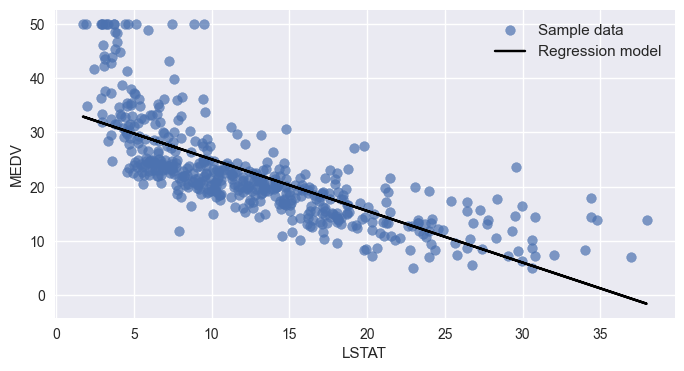

In [14]:
def plot_regression_2d(X, y_true, y_predict, xlabel='LSTAT', ylabel='MEDV'):
    fig, ax = plt.subplots(figsize=(8, 4)) #фигура + координатная плоскость
    ax.scatter(X, y_true, alpha=0.7, label='Sample data') #диаграмма рассеяния
    ax.plot(X, y_predict, color='black', label='Regression model') #линейный график
    ax.set_xlabel(xlabel) #название оси абсцисс
    ax.set_ylabel(ylabel) #название оси ординат
    ax.legend(facecolor='white', fontsize=11) #легенда
    #Делаем предсказание для всех объектов из таблицы
y_predict = w[0] + w[1] * X
#Строим визуализацию
plot_regression_2d(X, y, y_predict)

Как и ожидалось, прямая является убывающей (коэффициент w1<0 ), и, если её продолжить влево, она пересечётся с осью ординат в точке w0=34.55 . 